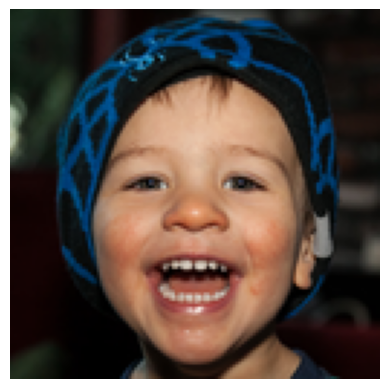

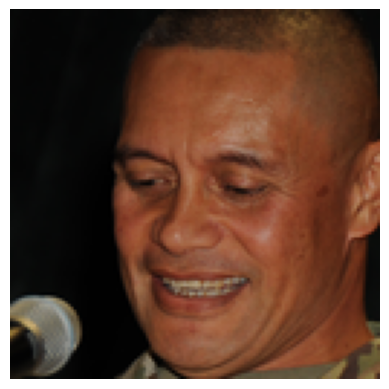

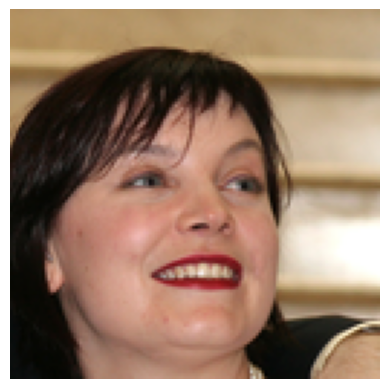

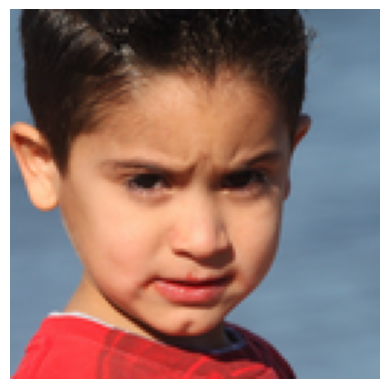

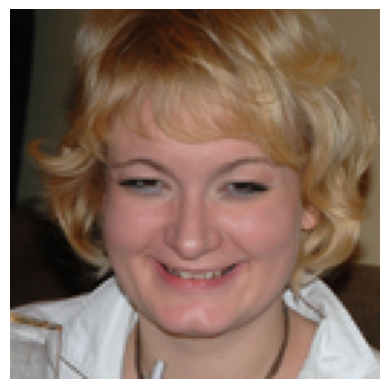

In [2]:
!pip install matplotlib pillow

import matplotlib.pyplot as plt
from PIL import Image

image_dir = "C:/Users/bhara/python_codes/100photos"


import os

image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

sample = 5

for i in range(sample):
    image_path = os.path.join(image_dir, image_files[i])
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

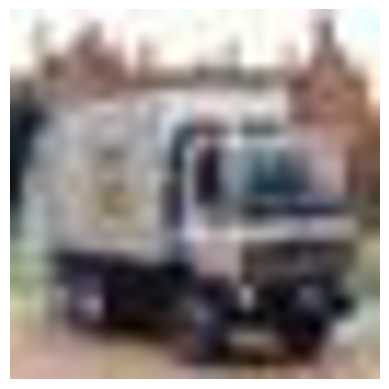

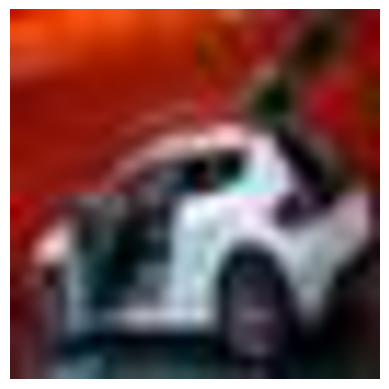

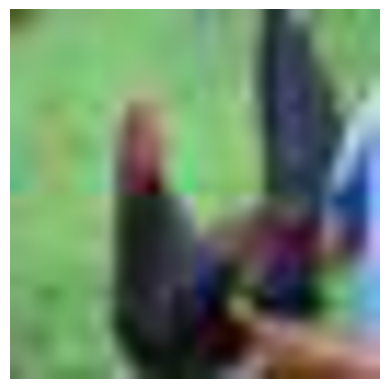

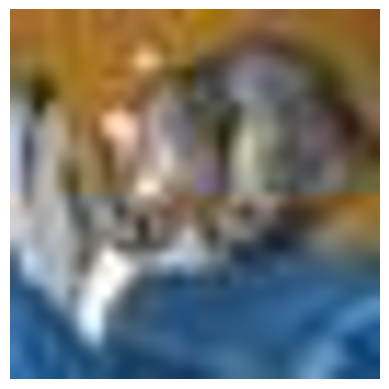

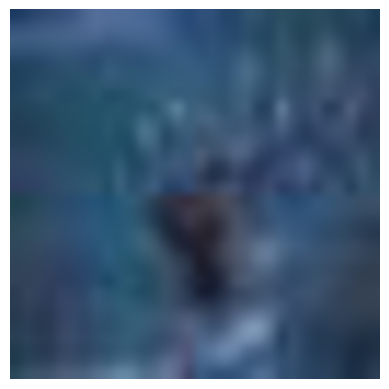

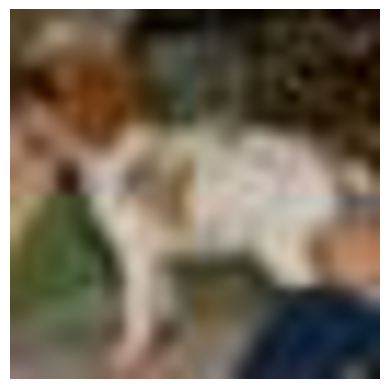

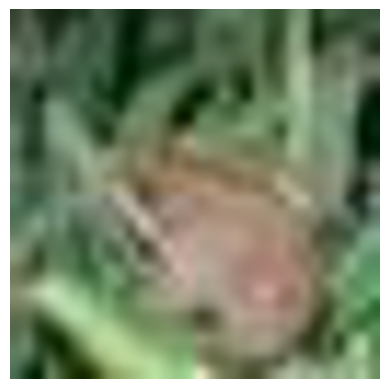

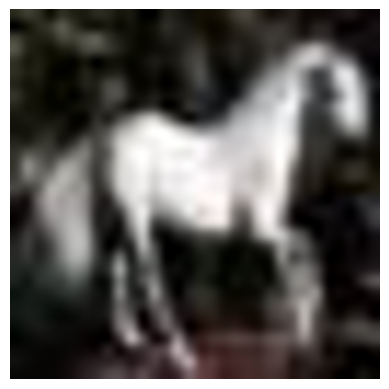

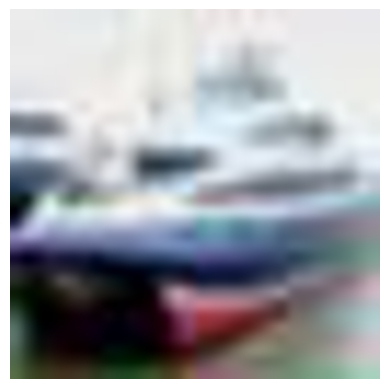

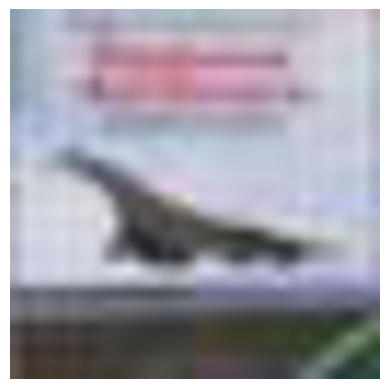

In [4]:
###Resized sample images

sample =  10
target_size = (1024,1024)

for i in range(sample):
    image_path = os.path.join(image_dir, image_files[i])
    image = Image.open(image_path)
    image = image.resize(target_size)
    
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [ ]:
!pip install matplotlib pillow

import matplotlib.pyplot as plt
from PIL import Image

image_dir = "C:/Users/bhara/python_codes/test/REAL"

#  GAN

In [13]:
pip install torchvision
# pip install torch


SyntaxError: invalid syntax (1928194510.py, line 1)

In [14]:
pip install torchvision

     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
     ----- ---------------------------------- 0.2/1.2 MB 4.6 MB/s eta 0:00:01
     ------------------------------------ --- 1.1/1.2 MB 13.9 MB/s eta 0:00:01
     ---------------------------------------- 1.2/1.2 MB 10.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values
])


In [5]:
from google.colab import drive
drive.mount('/content/drive')


ModuleNotFoundError: No module named 'google'

In [51]:
local_data_path = 'C:/Users/bhara/python_codes/100photos'


train_dataset = datasets.CIFAR10(root=local_data_path,\
			train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, \
								batch_size=16, shuffle=True)


Files already downloaded and verified


In [52]:
# Hyperparameters
latent_dim = 100
lr = 0.0001
beta1 = 0.9
beta2 = 0.999
num_epochs = 10


In [68]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (512, 8, 8)),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # Upsample to 16x16
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # Upsample to 32x32
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # Upsample to 64x64
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # Upsample to 128x128
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img


In [54]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity


In [55]:
# Define the generator and discriminator
# Initialize generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters()\
						, lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters()\
						, lr=lr, betas=(beta1, beta2))


In [38]:
# Training loop
for epoch in range(num_epochs):
	for i, batch in enumerate(dataloader):
	# Convert list to tensor
		real_images = batch[0].to(device)

		# Adversarial ground truths
		valid = torch.ones(real_images.size(0), 1, device=device)
		fake = torch.zeros(real_images.size(0), 1, device=device)

		# Configure input
		real_images = real_images.to(device)

		# ---------------------
		# Train Discriminator
		# ---------------------

		optimizer_D.zero_grad()

		# Sample noise as generator input
		z = torch.randn(real_images.size(0), latent_dim, device=device)

		# Generate a batch of images
		fake_images = generator(z)

		# Measure discriminator's ability
		# to classify real and fake images
		real_loss = adversarial_loss(discriminator\
									(real_images), valid)
		fake_loss = adversarial_loss(discriminator\
									(fake_images.detach()), fake)
		d_loss = (real_loss + fake_loss) / 2

		# Backward pass and optimize
		d_loss.backward()
		optimizer_D.step()

		# -----------------
		# Train Generator
		# -----------------

		optimizer_G.zero_grad()

		# Generate a batch of images
		gen_images = generator(z)

		# Adversarial loss
		g_loss = adversarial_loss(discriminator(gen_images), valid)

		# Backward pass and optimize
		g_loss.backward()
		optimizer_G.step()

		# ---------------------
		# Progress Monitoring
		# ---------------------

		if (i + 1) % 100 == 0:
			print(
				f"Epoch [{epoch+1}/{num_epochs}]\
						Batch {i+1}/{len(dataloader)} "
				f"Discriminator Loss: {d_loss.item():.4f} "
				f"Generator Loss: {g_loss.item():.4f}"
			)

	# Save generated images for every epoch
	if (epoch + 1) % 2 == 0:
		with torch.no_grad():
			z = torch.randn(16, latent_dim, device=device)
			generated = generator(z).detach().cpu()
			grid = torchvision.utils.make_grid(generated,\
										nrow=4, normalize=True)
			plt.imshow(np.transpose(grid, (1, 2, 0)))
			plt.axis("off")
			plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2048 and 8192x1)

In [20]:
# Adversarial loss
g_loss = adversarial_loss(discriminator(gen_images), valid)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2048 and 32768x1)

In [69]:
import os
import torch
import torchvision
import numpy as np

# Set up a directory to save generated images
os.makedirs("generated_images", exist_ok=True)

# Training loop
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
        # ... (existing code for GAN training)
        # Convert list to tensor
        real_images = batch[0].to(device)

        # Adversarial ground truths
        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)
        
        # Configure input
        real_images = real_images.to(device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = torch.randn(16, latent_dim, device=device)

        # Generate a batch of images
        fake_images = generator(z)

        # Measure discriminator's ability to classify real and fake images
        real_loss = adversarial_loss(discriminator(real_images), valid)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # Backward pass and optimize
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_images = generator(z)

        # Adversarial loss
        g_loss = adversarial_loss(discriminator(gen_images), valid)

        # Backward pass and optimize
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        # Progress Monitoring
        # ---------------------
        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}] "
                f"Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )

    # Save generated images for every epoch
    if (epoch + 1) % 2 == 0:
        with torch.no_grad():
            z = torch.randn(32, latent_dim, device=device)
            generated = generator(z).detach().cpu()

            # Save each generated image individually
            for j, image in enumerate(generated):
                image_filename = f"generated_images/epoch_{epoch+1}_image_{j+1}.png"
                torchvision.utils.save_image(image, image_filename)

                print(f"Saved generated image {j+1} for epoch {epoch+1} as {image_filename}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x2048 and 32768x1)

In [70]:
print("Input data shape:", real_images.shape)


Input data shape: torch.Size([16, 3, 32, 32])


In [71]:
print("Generated image shape:", fake_images.shape)


Generated image shape: torch.Size([16, 3, 32, 32])


In [72]:
print("Real images shape:", real_images.shape)
print("Generated images shape:", fake_images.shape)


Real images shape: torch.Size([16, 3, 32, 32])
Generated images shape: torch.Size([16, 3, 32, 32])


In [66]:
print("Discriminator output shape:", discriminator_output.shape)


NameError: name 'discriminator_output' is not defined